In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
sns.set_style('white')

In [2]:
data_path = Path('data', 'sentiment140')
if not data_path.exists():
    data_path.mkdir(parents=True)
names = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [3]:
def load_train_data():
    parquet_file = data_path / 'train.parquet'
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'train.csv', low_memory=False, encoding='latin1', header=None,
                          names=names, parse_dates=['date']).drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[df.text.str.len() <= 140]
        df.polarity = (df.polarity > 0).astype(int)
        df.to_parquet(parquet_file)
        return df
    else:
        return pd.read_parquet(parquet_file)
train = load_train_data()
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566668 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   polarity  1566668 non-null  int32         
 1   date      1566668 non-null  datetime64[ns]
 2   user      1566668 non-null  object        
 3   text      1566668 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 53.8+ MB


In [24]:
train.sample(10)

,polarity,date,user,text
1484335,1,2009-06-07 12:42:42,LauraEstevez320,@Cycast07 thanksss ily moree
550243,0,2009-06-16 22:33:29,jwoon888,we're back in the apt...only need to go to Mir...
41086,0,2009-04-21 03:40:07,uricahh,i'm having trouble getting out of bed.... i'm ...
1012191,1,2009-05-22 03:51:54,jfkjohan,Going through the SOPs for my first flight tom...
1012284,1,2009-05-22 03:53:54,Jkheary,never been so tired.... turbo shot
181475,0,2009-05-29 18:33:41,hernandezd09,home tired and is kinda upset
293541,0,2009-06-01 14:56:10,MikeyLotts,@kristenlawson I don't get off in time
888620,1,2009-05-03 08:26:12,yeahhsoimkatie,is tiiiiiired!
1565527,1,2009-06-15 20:28:49,belgort,@ericmack We are all ears http://linkjam.elgu...
1325625,1,2009-06-03 03:53:04,feline121,I am happy. The sun is shining. Life is just b...


In [4]:
def load_test_data():
    parquet_file = data_path / 'test.parquet'
    if not parquet_file.exists():
        df = (pd.read_csv('data/sentiment140/test.csv', low_memory=False, encoding='latin1', header=None,
                          names=names, parse_dates=['date']).drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[(df.text.str.len() <= 140) & (df.polarity.isin([0, 4]))]
        df.to_parquet(parquet_file)
        return df
    else:
        return pd.read_parquet(parquet_file)
test = load_test_data()
test.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 497
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   polarity  354 non-null    int64              
 1   date      354 non-null    datetime64[ns, UTC]
 2   user      354 non-null    object             
 3   text      354 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 13.8+ KB


In [25]:
test.sample(10)

,polarity,date,user,text,sentiment
228,0,2009-06-08 20:02:01+00:00,jesusmbaez,Safari 4 is fast :) Even on my shitty AT&amp;T...,0.350000
223,0,2009-06-08 19:59:16+00:00,jamesmakeseyes,#at&amp;t is complete fail.,-0.200000
313,1,2009-05-23 04:23:54+00:00,julieules,@tonyhawk http://twitpic.com/5c7uj - AWESOME!!...,1.000000
59,0,2009-05-18 01:18:03+00:00,wendy93639,omg. The commercials alone on ESPN are going t...,0.000000
43,0,2009-05-17 17:28:02+00:00,Whacktackular,"Blah, blah, blah same old same old. No plans t...",0.040000
476,1,2009-06-13 16:24:08+00:00,tessalau,Excited about seeing Bobby Flay and Guy Fieri ...,0.391667
225,0,2009-06-08 19:59:26+00:00,nakiasmile,@Mbjthegreat i really dont want AT&amp;T phone...,0.200000
275,1,2009-05-16 23:58:44+00:00,robotickilldozr,Lyx is cool.,0.350000
345,0,2009-05-25 17:35:43+00:00,joahs,obviously not siding with Cheney here: http://...,0.000000
68,1,2009-05-20 02:37:09+00:00,sportsgirl505,just changed my default pic to a Nike basketba...,1.000000


In [5]:
train.head()

,polarity,date,user,text
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

1    784335
0    782333
Name: polarity, dtype: int64

In [7]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

1    180
0    174
Name: polarity, dtype: int64

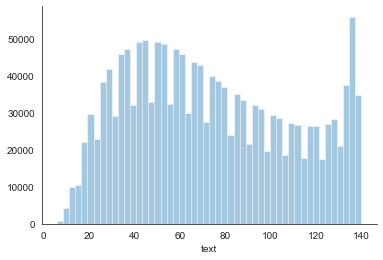

In [8]:
sns.distplot(train.text.str.len(), kde=False)
sns.despine();

In [9]:
train.date.describe()

count                 1566668
unique                 765666
top       2009-06-15 12:53:14
freq                       20
first     2009-04-06 22:19:45
last      2009-06-25 10:28:31
Name: date, dtype: object

In [10]:
train.user.nunique()

650606

In [11]:
train.user.value_counts().head(10)

lost_dog           549
webwoke            341
SallytheShizzle    276
VioletsCRUK        275
mcraddictal        274
tsarnick           247
what_bugs_u        246
Karen230683        237
DarkPiano          232
SongoftheOss       226
Name: user, dtype: int64

In [27]:
train.sample(10)

,polarity,date,user,text
129268,0,2009-05-18 05:03:05,fefmill705,@MissKatiePrice I really hope you both can wor...
1194785,1,2009-05-31 15:15:30,ixstillxsing,Out! Yesssss.
1246938,1,2009-06-01 13:28:30,RYANWWILLIAMS,@cambriadetken thanks!! I'm you're newest bigg...
196356,0,2009-05-30 04:53:52,seanmhair,Was considering switching to TekSavvy. Had qu...
1305574,1,2009-06-02 18:49:15,gmagssss,Taking a break from studyinggg. I really shoul...
1437600,1,2009-06-06 20:22:47,JimmiieJamees,"good night. i can't wait for monday, i am sick..."
1092278,1,2009-05-30 01:53:38,SteveGodbold,@tathamoddie I'm not worried about your workin...
479241,0,2009-06-15 08:13:30,darkknight89,Eating. Bored and frustrated. I wish I was h...
1568727,1,2009-06-15 21:35:19,BurningSunset,Im bored. Cant wait for the accesshollywood in...
304610,0,2009-06-01 20:48:26,kikimarie593,@JenJelly85 people on tv.com right now? I hate...


In [12]:
# Create text vectorizer
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

<1566668x934 sparse matrix of type '<class 'numpy.int64'>'
	with 6332930 stored elements in Compressed Sparse Row format>

In [13]:
test_dtm = vectorizer.transform(test.text)

In [14]:
# Train Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

MultinomialNB()

In [15]:
predicted_polarity = nb.predict(test_dtm)
accuracy_score(test.polarity, predicted_polarity)

0.7768361581920904

In [30]:
# TextBlob for Sentiment Analysis
sample_positive = train.text.loc[25632]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

good morning!! in about two hours im going to study  and ill will mis greys anatomy a lot im a hug fan!!! xoxo


0.01171875

In [35]:
sample_negative = train.text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

 i hate this place


-0.8

In [18]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

train[['text']].sample(10).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

,text,sentiment
479872,ugh! i hate having allergies,-0.800000
758832,Fact: Tyra Banks is stupid Fact#2: I have t...,-0.800000
992758,I am afraid if I say anymore the meter will st...,-0.750000
766889,"@sara_elizabetth they all get hurt really bad,...",-0.100000
394212,Why must my father be such a crab this morning?,0.000000
302221,Doing homework....only 10 more days of school ...,0.250000
1466586,@scottiejen good thanks me and mum1 booked ou...,0.300000
816094,@mileycyrus is so cute! I would love to meet ...,0.541667
729890,Just set the fire in the lounge room. Anything...,0.700000
88788,Wish I could be with ma dukes today! Happy Mo...,1.000000


In [19]:
# Compare with TextBlob Polarity Score
test['sentiment'] = test.text.apply(estimate_polarity)
accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

In [20]:
roc_auc_score(y_true=test.polarity, y_score=test.sentiment)

0.8254948914431672

In [21]:
roc_auc_score(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])

0.848595146871009

In [22]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

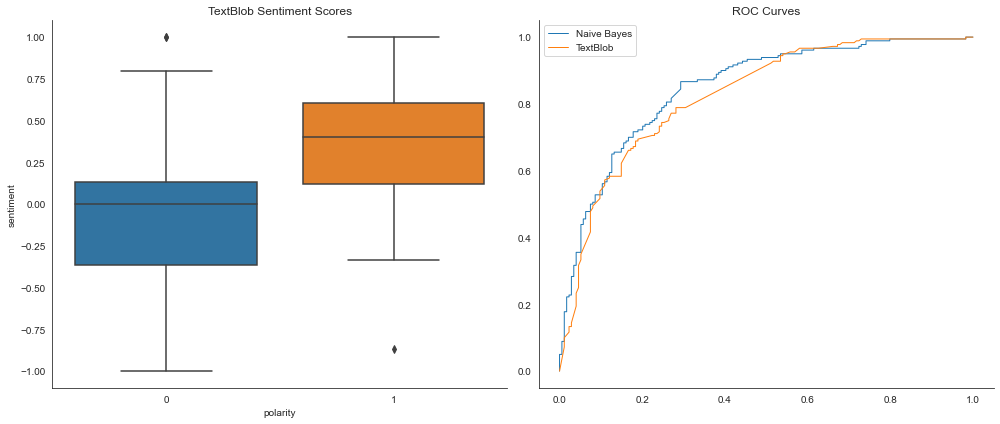

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
sns.despine()
fig.tight_layout();